In [2]:
import time
import numpy as np
from keras.utils import np_utils
import keras.callbacks as cb
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import feather 
from mailerWithUtf8 import mail
from sklearn.preprocessing import LabelEncoder
from keras.models import model_from_json

# preprocess load data

In [3]:
start_time = time.time()
# path = 'C:/Users/VIPLAB/Desktop/preprocess_py/marketing_analyze/0710_marketing_train.feather' 
path = 'C:/Users/VIPLAB/Desktop/preprocess_py/marketing_analyze/0710_marketing_train_sample.feather' 
train_df = feather.read_dataframe(path)
print('load feather %s seconds', format(time.time() - start_time))


load feather %s seconds 0.14971494674682617


In [4]:
start_time = time.time()
# path = 'C:/Users/VIPLAB/Desktop/preprocess_py/marketing_analyze/0710_marketing_test.feather'
path = 'C:/Users/VIPLAB/Desktop/preprocess_py/marketing_analyze/0710_marketing_test_sample.feather' 

test_df = feather.read_dataframe(path)
print('load feather %s seconds', format(time.time() - start_time))

load feather %s seconds 0.043143272399902344


In [5]:
train_x, train_y = train_df.iloc[:, 0:-1].values, train_df.iloc[:, -1].values

In [6]:
test_x, test_y = test_df.iloc[:, 0:-1].values, test_df.iloc[:, -1].values

In [7]:
train_x = train_x.reshape(train_x.shape[0], -1)   # normalize
test_x = test_x.reshape(test_x.shape[0], -1)   # normalize



In [8]:
# from sklearn.preprocessing import LabelBinarizer
# encoder = LabelBinarizer()
# y_train = encoder.fit_transform(y_train)
# y_test = encoder.fit_transform(y_test)

In [9]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
encoded_Y = encoder.transform(train_y)
# convert integers to dummy variables (i.e. one hot encoded)
train_y = np_utils.to_categorical(encoded_Y)

encoded_Y = encoder.transform(test_y)
# convert integers to dummy variables (i.e. one hot encoded)
test_y = np_utils.to_categorical(encoded_Y)

In [10]:
# get y unique name
encoder.classes_

array(['Adult', 'Game', 'HomeLife', 'Infrequent Internet User',
       'InstantMessage-High', 'InstantMessage-Low', 'Map', 'News',
       'No significant preference', 'Portal', 'Social-media'], dtype=object)

In [11]:
len(train_y)

150610

In [12]:
len(test_y)

37653

# construct and compile model

In [13]:
classify_num = 11
epochs = 300
batch = 128

# basic config

In [14]:
start_time = time.time()
print ('Compiling Model ... ')
model = Sequential()
model.add(Dense(256, input_shape=train_x[0].shape ))
model.add(Activation('relu'))
# model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
# model.add(Dropout(0.2))
model.add(Dense(classify_num))
model.add(Activation('softmax'))

rms = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=rms,
          metrics=['accuracy'])
print('Model compield in {0} seconds'.format(time.time() - start_time))


Compiling Model ... 
Model compield in 0.10224437713623047 seconds


# Train model

In [12]:
start_time = time.time()
print('Training model...')
model.fit(train_x, train_y , epochs=epochs, batch_size=batch,
          shuffle=True,validation_split=0.1, verbose=2)
print("Training duration : {0}".format(time.time() - start_time))


Training model...
Train on 1355492 samples, validate on 150611 samples
Epoch 1/300
50s - loss: 1.9520 - acc: 0.2980 - val_loss: 1.9404 - val_acc: 0.3020
Epoch 2/300
48s - loss: 1.9128 - acc: 0.3090 - val_loss: 1.9146 - val_acc: 0.3084
Epoch 3/300
48s - loss: 1.8996 - acc: 0.3115 - val_loss: 1.8949 - val_acc: 0.3132
Epoch 4/300
49s - loss: 1.8933 - acc: 0.3138 - val_loss: 1.8912 - val_acc: 0.3162
Epoch 5/300
49s - loss: 1.8909 - acc: 0.3140 - val_loss: 1.8953 - val_acc: 0.3147
Epoch 6/300
50s - loss: 1.8891 - acc: 0.3151 - val_loss: 1.8932 - val_acc: 0.3129
Epoch 7/300
47s - loss: 1.8871 - acc: 0.3155 - val_loss: 1.8864 - val_acc: 0.3146
Epoch 8/300
45s - loss: 1.8849 - acc: 0.3161 - val_loss: 1.8831 - val_acc: 0.3176
Epoch 9/300
45s - loss: 1.8839 - acc: 0.3167 - val_loss: 1.8980 - val_acc: 0.3158
Epoch 10/300
46s - loss: 1.8837 - acc: 0.3167 - val_loss: 1.8812 - val_acc: 0.3199
Epoch 11/300
46s - loss: 1.8820 - acc: 0.3171 - val_loss: 1.8862 - val_acc: 0.3166
Epoch 12/300
46s - loss: 

51s - loss: 1.8791 - acc: 0.3220 - val_loss: 1.8976 - val_acc: 0.3177
Epoch 100/300
53s - loss: 1.8796 - acc: 0.3221 - val_loss: 1.9018 - val_acc: 0.3171
Epoch 101/300
52s - loss: 1.8807 - acc: 0.3220 - val_loss: 1.8958 - val_acc: 0.3170
Epoch 102/300
52s - loss: 1.8817 - acc: 0.3218 - val_loss: 1.9046 - val_acc: 0.3184
Epoch 103/300
52s - loss: 1.8808 - acc: 0.3218 - val_loss: 1.8917 - val_acc: 0.3173
Epoch 104/300
54s - loss: 1.8779 - acc: 0.3222 - val_loss: 1.8948 - val_acc: 0.3182
Epoch 105/300
53s - loss: 1.8788 - acc: 0.3222 - val_loss: 1.8883 - val_acc: 0.3217
Epoch 106/300
53s - loss: 1.8782 - acc: 0.3226 - val_loss: 1.8984 - val_acc: 0.3200
Epoch 107/300
50s - loss: 1.8792 - acc: 0.3224 - val_loss: 1.9073 - val_acc: 0.3138
Epoch 108/300
55s - loss: 1.8783 - acc: 0.3223 - val_loss: 1.9093 - val_acc: 0.3111
Epoch 109/300
52s - loss: 1.8788 - acc: 0.3222 - val_loss: 1.8931 - val_acc: 0.3170
Epoch 110/300
53s - loss: 1.8786 - acc: 0.3223 - val_loss: 1.8878 - val_acc: 0.3215
Epoch 

51s - loss: 1.8858 - acc: 0.3221 - val_loss: 1.9223 - val_acc: 0.3187
Epoch 198/300
50s - loss: 1.8875 - acc: 0.3226 - val_loss: 1.9046 - val_acc: 0.3179
Epoch 199/300
54s - loss: 1.8870 - acc: 0.3224 - val_loss: 1.9076 - val_acc: 0.3187
Epoch 200/300
52s - loss: 1.8861 - acc: 0.3223 - val_loss: 1.9252 - val_acc: 0.3077
Epoch 201/300
51s - loss: 1.8857 - acc: 0.3225 - val_loss: 1.9005 - val_acc: 0.3191
Epoch 202/300
49s - loss: 1.8863 - acc: 0.3224 - val_loss: 1.9002 - val_acc: 0.3205
Epoch 203/300
53s - loss: 1.8852 - acc: 0.3219 - val_loss: 1.9038 - val_acc: 0.3147
Epoch 204/300
54s - loss: 1.8851 - acc: 0.3223 - val_loss: 1.9155 - val_acc: 0.3165
Epoch 205/300
56s - loss: 1.8853 - acc: 0.3226 - val_loss: 1.9117 - val_acc: 0.3154
Epoch 206/300
53s - loss: 1.8857 - acc: 0.3228 - val_loss: 1.9031 - val_acc: 0.3183
Epoch 207/300
54s - loss: 1.8884 - acc: 0.3225 - val_loss: 1.9116 - val_acc: 0.3142
Epoch 208/300
51s - loss: 1.8864 - acc: 0.3224 - val_loss: 1.9129 - val_acc: 0.3154
Epoch 

49s - loss: 1.9142 - acc: 0.3213 - val_loss: 1.9368 - val_acc: 0.3146
Epoch 296/300
47s - loss: 1.9290 - acc: 0.3214 - val_loss: 1.9253 - val_acc: 0.3180
Epoch 297/300
47s - loss: 1.9478 - acc: 0.3211 - val_loss: 2.0272 - val_acc: 0.3166
Epoch 298/300
48s - loss: 1.9354 - acc: 0.3210 - val_loss: 1.9297 - val_acc: 0.3188
Epoch 299/300
48s - loss: 1.9192 - acc: 0.3213 - val_loss: 1.9303 - val_acc: 0.3169
Epoch 300/300
48s - loss: 1.9346 - acc: 0.3210 - val_loss: 1.9317 - val_acc: 0.3158
Training duration : 15664.750354290009


In [13]:
train_time = time.time() - start_time

# save model

In [14]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 


Saved model to disk


# test model and get accuracy

In [15]:
test_batch = 32
loss, accuracy = model.evaluate(test_x, test_y, batch_size=test_batch)

376064/376526 [============================>.] - ETA: 0s

In [16]:
print("%s: %.2f%%" % (model.metrics_names[1], accuracy*100))


acc: 31.46%


# send mail to alert

In [17]:
model_config = []
for index, layer in enumerate(model.get_config()):
    model_config.append("layer - > %d===============" % index)
    model_config.append("class_name = " + layer["class_name"] )
    if(str(layer["config"].get("units", "None")) != "None"):
        model_config.append("units = " + str(layer["config"].get("units", "None")))
    if(str(layer["config"].get("activation", "None")) != "None"):
        model_config.append("activation = " + layer["config"]["activation"])
    if(str(layer["config"].get("rate", "None")) != "None"):
        model_config.append("rate = " + str(layer["config"]["rate"]))
model_info = '\n'.join(model_config)

In [18]:
model_info += "\n\ntrain epochs = " + str(epochs)
model_info += "\ntrain batch = " + str(batch)
model_info += "\ntest batch = " + str(test_batch)
model_info += "\ntrain time = " + str(train_time)
model_info += "\nloss = " + str(loss)
model_info += "\n\n\naccuracy = " + str(accuracy)



In [19]:
test=mail()
test.main("model finished", model_info)

Start Send Mail
User Email : a - DONE 
User Email : a - DONE 
User Email : 2 - DONE 
User Email : 6 - DONE 
User Email : 3 - DONE 
User Email : 6 - DONE 
User Email : 5 - DONE 
User Email : 5 - DONE 
User Email : 6 - DONE 
User Email : 6 - DONE 
User Email : @ - DONE 
User Email : g - DONE 
User Email : m - DONE 
User Email : a - DONE 
User Email : i - DONE 
User Email : l - DONE 
User Email : . - DONE 
User Email : c - DONE 
User Email : o - DONE 
User Email : m - DONE 
Finish Send Mail


# write readme to report the model

In [20]:
md_info = model_info.replace("\n", "<br>")
with open('readme.md', 'w+') as f:
     f.write(md_info)
f.closed

True

In [21]:
print(model_info)

layer - > 0===============
class_name = Dense
units = 256
activation = linear
layer - > 1===============
class_name = Activation
activation = relu
layer - > 2===============
class_name = Dense
units = 128
activation = linear
layer - > 3===============
class_name = Activation
activation = relu
layer - > 4===============
class_name = Dense
units = 64
activation = linear
layer - > 5===============
class_name = Activation
activation = relu
layer - > 6===============
class_name = Dense
units = 32
activation = linear
layer - > 7===============
class_name = Activation
activation = relu
layer - > 8===============
class_name = Dense
units = 11
activation = linear
layer - > 9===============
class_name = Activation
activation = softmax

train epochs = 300
train batch = 128
test batch = 32
train time = 15664.768165111542
loss = 1.93175412251


accuracy = 0.314644938199


In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
pred = model.predict(test_x)

In [27]:
cnf_matrix = confusion_matrix(np.argmax(test_y, axis = 1), np.argmax(pred, axis = 1))
cnf_matrix

array([[    0,     0,     0,   296,  2723,  1968,     0,     0,  5371,
          522,     0],
       [    0,     0,     0,  1544,  6443,  3787,     1,     0,  5039,
          477,     0],
       [    0,     0,     1,   488,  3346,  5943,     1,     0,  4750,
          501,     0],
       [    0,     0,     0, 20547,  5729,   317,     0,     0,  2327,
           45,     0],
       [    0,     0,     2, 10806, 40654, 19170,     9,     0, 13118,
         1163,     0],
       [    0,     0,     2,  4129, 29556, 33319,    10,     0, 17645,
         1516,     0],
       [    0,     0,     0,   229,  6794, 13455,     5,     0,   509,
           29,     0],
       [    0,     0,     0,  1397,  4521,  1520,     1,     0,  3772,
          163,     0],
       [    0,     0,     0,  4508, 13780, 11073,     4,     0, 22658,
         1381,     0],
       [    0,     0,     1,  2193,  5753,  1248,     0,     0,  9084,
         1288,     0],
       [    0,     0,     0,  2431, 11515,  6095,     1,    

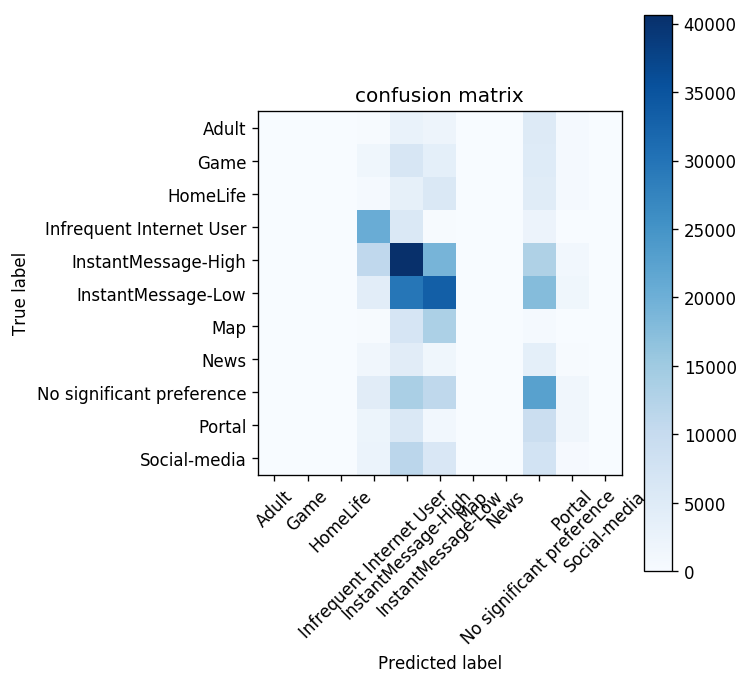

In [36]:
np.set_printoptions(precision=2)
plt.figure(figsize=(6, 6), dpi = 120)
plot_confusion_matrix(cnf_matrix, classes=encoder.classes_, normalize=True, title='confusion matrix')
plt.show()

In [110]:
# for i in range(10):
#     probabilities = model.predict(test_x[i:i+1,:], batch_size=32, verbose=0)
#     probabilities = model.predict(test_x[i:i+1,:])
#     probabilities = model.predict(test_x)
#     probabilities[probabilities>=0.5] = 1
#     probabilities[probabilities<0.5] = 0
#     print(probabilities)

[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
